## Data analysis for:

## Validation of tail mounted triaxial accelerometer for measuring foals´ lying and motor behavior

#### Nina Pirinen$^a$,*, Matti Pastell$^b$, Anna Mykkänen$^a$, Catherine McGowan$^c$, Heli Hyytiäinen$^b$


a Department of Equine and Small Animal Medicine, Faculty of Veterinary Medicine, University of Helsinki, Viikintie 49, P.O. Box 57, 00014 Helsinki, Finland

b Natural Resources Institute of Finland (Luke), Production Systems, PO Box 2, FI-00791 Helsinki, Finland

c School of Veterinary Science, Institute of Ageing and Chronic Disease, University of Liverpool, Liverpool, England


## Running the analysis

The data analysis was conducted using [Julia](https://julialang.org/) language version 1.1. using a [Jupyter](https://jupyter.org/) notebook. In order to run the analysis you need to install Julia and IJulia kernel and open the notebook in Jupyter. 

The analysis has been set up as Julia project. You can download the project from github and run the ful analysis in `FoalBehavior_supplementary_notebook.ipynb` (this document).

The following commands activate the project, and install depencencies:

In [46]:
using Pkg; Pkg.activate(".")
Pkg.instantiate() # Run this to install dependencies, only needed at first run 

  Updating registry at `C:\Users\03080535\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


┌ Warning: Some registries failed to update:
│     — C:\Users\03080535\.julia\registries\General — failed to fetch from repo
└ @ Pkg.Types C:\cygwin\home\Administrator\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.1\Pkg\src\Types.jl:1269


In [47]:
using StatsPlots, Distributions, CSV, DataFrames, Optim, MLBase
include("utils.jl")
gr(fmt=:png)

Plots.GRBackend()

## Load data

In [48]:
foals = CSV.read("csv/foal_data.csv");

## Calculate features from accelerometer data

Tilt angles between different axis and gravity vector:

$$
\theta = \text{tan}^{-1}\frac{x_{avg}}{\sqrt{y_{avg}^2  + z_{avg}^2}}\\
\psi = \text{tan}^{-1}\frac{y_{avg}}{\sqrt{x_{avg}^2  + z_{avg}^2}}\\
\phi = \text{tan}^{-1}\frac{\sqrt{x_{avg}^2 + y_{avg}^2}}{z_{avg}}
$$

Dynamic body acceleration (DBA):

$$\text{DBA} = x_{range} + y_{range} + z_{range}$$

In [49]:
foals[:θ] = atan.(foals[:X_avg], sqrt.(foals[:Y_avg].^2 + foals[:Z_avg].^2))
foals[:ψ] = atan.(foals[:Y_avg], sqrt.(foals[:X_avg].^2 + foals[:Z_avg].^2))
foals[:ϕ] = atan.(sqrt.(foals[:X_avg].^2 + foals[:Y_avg].^2), foals[:Z_avg])
foals[:DBA] = foals[:X_range] .+ foals[:Y_range] .+ foals[:Z_range];

## Plot density estimates features vs observed behavior

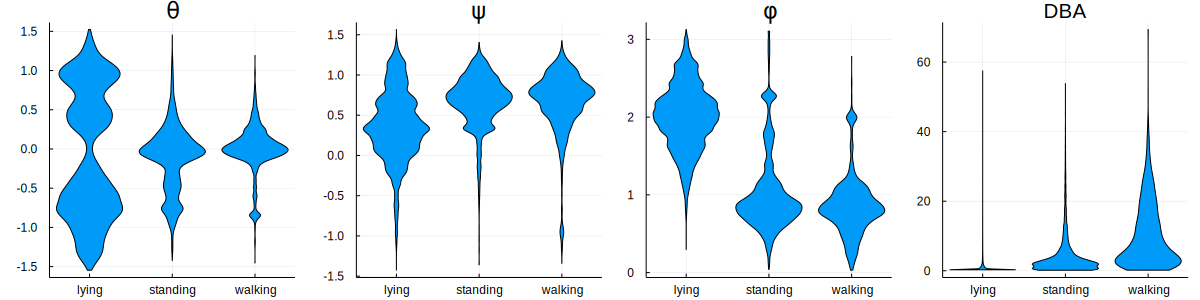

In [50]:
plot(violin(foals[:behavior], foals[:θ], title = "\\theta"),
    violin(foals[:behavior], foals[:ψ], title="\\psi"),
    violin(foals[:behavior], foals[:ϕ], title = "\\phi"),
    violin(foals[:behavior], foals[:DBA], title="DBA"),
    fmt = :svg, layout=(1,4), size=(1200,300), legend=false
)

## Split dataset

Data was split to training and validation datasets by randomly selecting 4 (out of 7) healthy foals and 2 (out of 4) sick foals to be used for training i.e fitting the naive Bayes classifier. The data from remaining foals was used for model validation. The split resulted in 31314 samples in the training dataset and 43032 in the validation dataset.

In [28]:
healthy = unique(foals[foals[:status] .== "healthy", :foalNo])
sick = unique(foals[foals[:status] .== "sick", :foalNo])

#Select random foals using
#train_IDs = [sample(healthy, 4, replace=false); sample(sick, 2, replace=false)]
train_IDs = Int64[2, 7, 9, 8, 6, 5] # This was the random split obtained for the paper

# training and validation datasets
t_foals = foals[(foals[:foalNo] .∈ [train_IDs]), :]
v_foals = foals[.!(foals[:foalNo] .∈ [train_IDs]), :]

DataFrame(n_train = nrow(t_foals), n_validation = nrow(v_foals))

,n_train,n_validation
,Int64,Int64
1,31314,43032


## Fit distribution to training data

`Distributions.jl` package doesn't currently have a method for fitting Weibull distribution so the below definition using Nelder-Mead method was used.

In [29]:
function Distributions.fit(T::Type{Distributions.Weibull}, x)
    function minw(params)
        pr = exp.(params) # Avoid negative values
        pr .+= 1e-5 # Avoid zero
        d = Weibull(pr[1], pr[2])
        return -loglikelihood(d, x)
    end
    p0 = rand(2) .+ 1.
    nm = optimize(minw, p0, NelderMead(),
        Optim.Options(show_trace=false))
    mu, s = exp.(nm.minimizer)
    return Distributions.Weibull(mu,s)
end

We fitted the Normal distribution to $\phi$ and Weibull distribution to DBA for each class in the training dataset  

In [30]:
function fit_feature(df::DataFrame, feature::Symbol, behavior::String, distribution)
       x = df[df[:behavior] .== behavior, feature]
       return fit(distribution, x)
end

function fit_weibull(df::DataFrame, feature::Symbol)
    behaviors = ["lying", "standing", "walking"]
    dists = Distribution[]
    for b in behaviors
        push!(dists, fit_feature(df, feature, b, Weibull))
    end
    return dists
end

function fit_normal(df::DataFrame, feature::Symbol)
    behaviors = ["lying", "standing", "walking"]
    dists = Distribution[]
    for b in behaviors
        x = df[df[:behavior] .== b, feature]
        if b == "standing"
            d = Normal(mean(trim(x, prop= .05)), std(trim(x, prop=.05))) # Trimmed mean for standing
        else
            d = Normal(mean(x), std(x))
        end
        push!(dists, d)
    end
    return dists
end

Dϕ = fit_normal(t_foals, :ϕ)
Ddba = fit_weibull(t_foals, :DBA);

In [31]:
behaviors = ["lying", "standing", "walking"]
display_results(behaviors, Dϕ, Ddba)

behavior,"ϕ: Normal(μ, σ)","DBA: Weibull(α, θ)"
lying,"μ = 1.96, σ = 0.362","α = 0.62 , θ = 0.257"
standing,"μ = 0.94, σ = 0.434","α = 0.75 , θ = 3.474"
walking,"μ = 0.77, σ = 0.288","α = 1.25 , θ = 12.632"


We explored the fits by plotting the histogram of data with fitted distibution

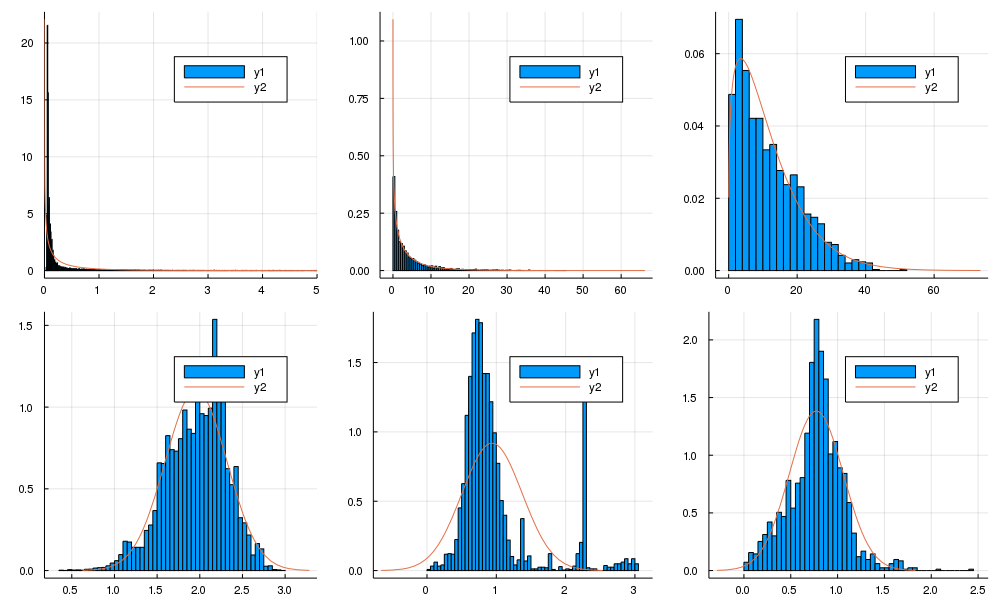

In [32]:
function feature_hist(df::DataFrame, feature::Symbol, behavior::String)
       x = df[df[:behavior] .== behavior, feature]
       histogram(x, normalize=true)
end

p1= feature_hist(t_foals, :DBA, "lying")
plot!(Ddba[1], xlim=(0,5))
p2 = feature_hist(t_foals, :DBA, "standing")
plot!(Ddba[2])
p3 = feature_hist(t_foals, :DBA, "walking")
plot!(Ddba[3])
p4 = feature_hist(t_foals, :ϕ, "lying")
plot!(Dϕ[1])
p5 = feature_hist(t_foals, :ϕ, "standing")
plot!(Dϕ[2])
p6 = feature_hist(t_foals, :ϕ, "walking")
plot!(Dϕ[3])

plot(p1, p2, p3, p4, p5, p6, layout=(2,3), size=(1000,600))

Plot fitted distributions in the same plot to observe overlap between classes

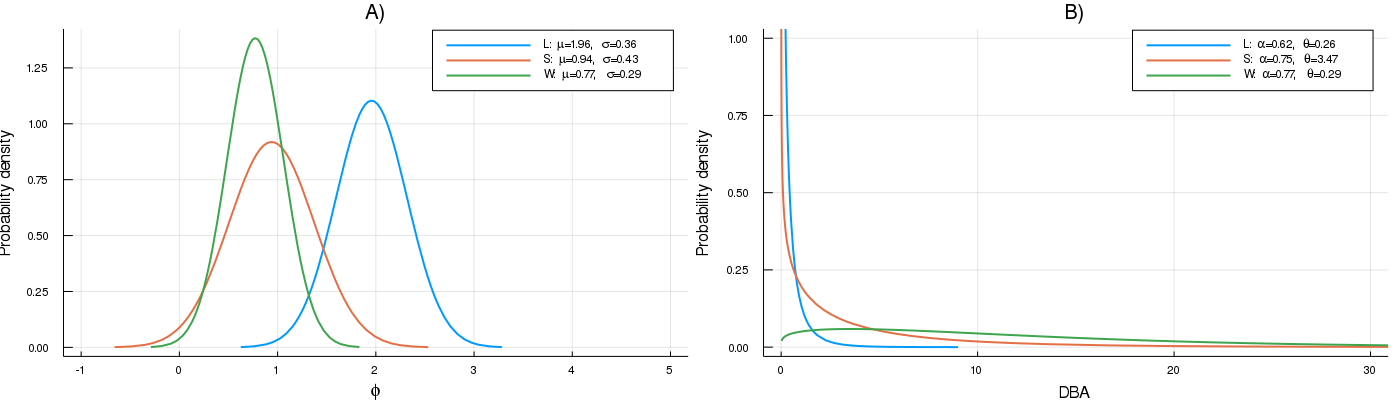

In [33]:
p1 = plot(Dϕ, legend=(.77, .95), xlim = [-1, 5.], 
    labels=["L: \\mu=1.96, \\sigma=0.36", "S: \\mu=0.94, \\sigma=0.43", "W: \\mu=0.77, \\sigma=0.29"], 
    lw=2, xlabel="\\phi", ylabel="Probability density", title="A)") 
p2 = plot(Ddba, ylim=[0, 1.], xlim=[0,30.], 
    labels=["L: \\alpha=0.62, \\theta=0.26", "S: \\alpha=0.75, \\theta=3.47", "W: \\alpha=0.77, \\theta=0.29"],
    lw=2, xlabel="DBA", ylabel="Probability density", title="B)", legend=(0.77, .95))


plot(p1, p2, size=(1400,400))

## Evaluate model on the validation dataset

Compute $p(C_k | \phi)$ and  $p(C_k | DBA)$ and $C_{pred} = \text{argmax}(p(C_k | \phi) \cdot p(C_k | DBA))$

In [34]:
class_probs(df, distributions, feature) = hcat((pdf.(d, v_foals[feature]) for d in distributions)...)
pdba = class_probs(v_foals, Ddba, :DBA)
pϕ = class_probs(v_foals, Dϕ, :ϕ);
joint = (pdba .* pϕ);
Cpred = [argmax(joint[r,:]) for r in 1:size(joint,1)];

### Plot true and predicted values

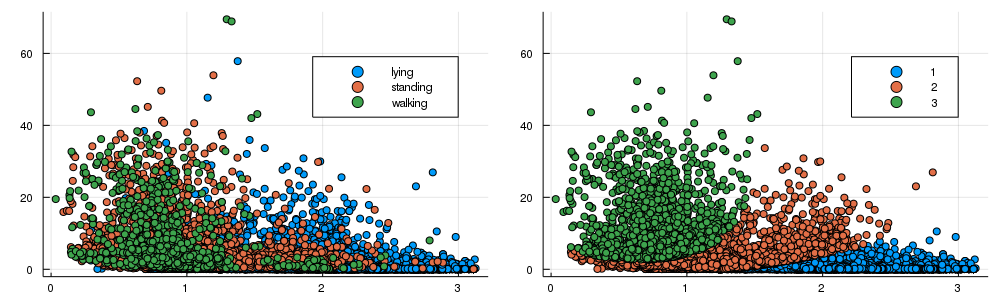

In [35]:
p1 = scatter(v_foals[:ϕ], v_foals[:DBA], group= v_foals[:behavior])
p2 = scatter(v_foals[:ϕ], v_foals[:DBA], group= Cpred)
plot(p1, p2, layout=(1,2), size=(1000,300))

### Assessing performance: Lying, Standing and Moving

Confusion matrix of predictions

In [36]:
lm = labelmap(["lying", "standing", "walking"])
it = labelencode(lm, String.(v_foals[:behavior]));
confusmat(3, Cpred, it)

3×3 Array{Int64,2}:
 34792   449  119
  2820  2744  354
   124  1213  417

Calculate performance metrics

In [37]:
function accuracy(rocs)
    tp = true_positive(rocs)
    tn = true_negative(rocs)
    fp = false_positive(rocs)
    fn = false_negative(rocs)
    return (tp+tn)/(tp+fp+fn+tn)
end;

In [38]:
rocs = [roc(it .== i, Cpred .==i) for i in 1:3]
DataFrame(accuracy = round.(accuracy.(rocs), digits=2),
          precision = round.(precision.(rocs), digits=2),
          specifity = round.(true_positive_rate.(rocs), digits=2),
          sensitivity = round.(true_negative_rate.(rocs), digits=2),
          f1 = round.(f1score.(rocs), digits=2))

,accuracy,precision,specifity,sensitivity,f1
,Float64,Float64,Float64,Float64,Float64
1,0.92,0.98,0.92,0.89,0.95
2,0.89,0.46,0.62,0.92,0.53
3,0.96,0.24,0.47,0.97,0.32


### Assessing performance: Lying and Standing only

Due to poor precision in differentiating between standing and walking we also evaluated the performance of two class classification "Lying" vs "Standing" where walking has also been merged to "Standing class".

In [39]:
rocs = roc(Cpred .> 1, it .> 1)
DataFrame(accuracy = round.(accuracy(rocs), digits=2),
          precision = round.(precision(rocs), digits=2),
          specifity = round.(true_positive_rate(rocs), digits=2),
          sensitivity = round.(true_negative_rate(rocs), digits=2),
          f1 = round.(f1score(rocs), digits=2))

,accuracy,precision,specifity,sensitivity,f1
,Float64,Float64,Float64,Float64,Float64
1,0.92,0.89,0.62,0.98,0.73


In [40]:
confusmat(2, (Cpred .> 1) .+1, (it .> 1).+1)

2×2 Array{Int64,2}:
 34792   568
  2944  4728